In [1]:
require('ggplot2')
require('nls.multstart')
require('broom')
require('tidyverse')
require('rTPC')
require('dplyr')

#git is not easy

rm(list=ls())
graphics.off()

Loading required package: ggplot2

Loading required package: nls.multstart

Loading required package: broom

Loading required package: tidyverse

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘tidyverse’”
Loading required package: rTPC

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#take a look at the different models available
get_model_names()

[1] "beta_2012"             "boatman_2017"          "briere2_1999"         
 [4] "delong_2017"           "flinn_1991"            "gaussian_1987"        
 [7] "hinshelwood_1947"      "joehnk_2008"           "johnsonlewin_1946"    
[10] "kamykowski_1985"       "lactin2_1995"          "modifiedgaussian_2006"
[13] "oneill_1972"           "pawar_2018"            "quadratic_2008"       
[16] "ratkowsky_1983"        "rezende_2019"          "sharpeschoolfull_1981"
[19] "sharpeschoolhigh_1981" "sharpeschoollow_1981"  "spain_1982"           
[22] "thomas_2012"           "thomas_2017"           "weibull_1995"

In [3]:
#read in the trait data
final_trait_data <- read.csv('../data/Final_Traitofinterest.csv')

In [4]:
#remove completely irrelevant columns
df <- final_trait_data[,colSums(is.na(final_trait_data))<nrow(final_trait_data)]

#filter to single species and trait
df2 <- dplyr::filter(df, interactor1 == 'Aedes albopictus'& originaltraitname == 'Development Rate')

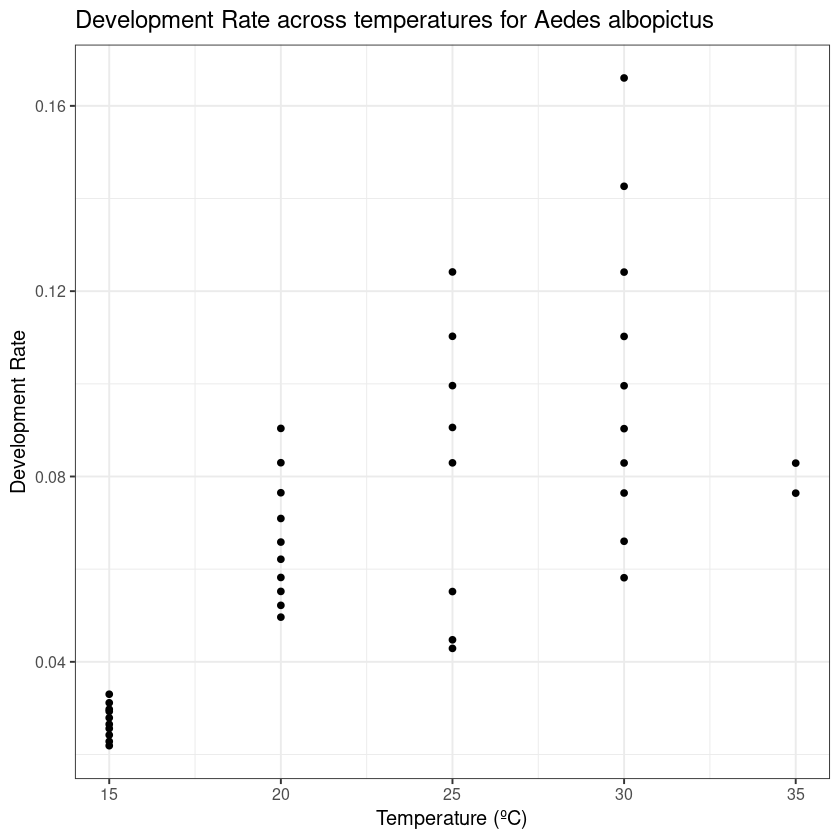

In [5]:
#visualize
ggplot(df2, aes(ambienttemp, originaltraitvalue))+
  geom_point()+
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Development Rate',
       title = 'Development Rate across temperatures for Aedes albopictus')

In [6]:
# choose model
mod = 'sharpschoolhigh_1981'

# get start vals
start_vals <- get_start_vals(df2$ambienttemp, df2$originaltraitvalue, model_name = 'sharpeschoolhigh_1981')

In [7]:
# get limits
low_lims <- get_lower_lims(df2$ambienttemp, df2$originaltraitvalue, model_name = 'sharpeschoolhigh_1981')
upper_lims <- get_upper_lims(df2$ambienttemp, df2$originaltraitvalue, model_name = 'sharpeschoolhigh_1981')

In [8]:
start_vals

r_tref           e          eh          th 
 0.06905828  0.60095423  0.31244305 30.83333333

In [9]:
low_lims

r_tref      e     eh     th 
     0      0      0      1

In [10]:
upper_lims

r_tref        e       eh       th 
 0.16602 10.00000 20.00000 35.00000

In [11]:
# fit model
fit <- nls_multstart(originaltraitvalue~sharpeschoolhigh_1981(temp = ambienttemp, r_tref,e,eh,th, tref = 15),
                     data = df2,
                     iter = 500,
                     start_lower = start_vals - 10,
                     start_upper = start_vals + 10,
                     lower = low_lims,
                     upper = upper_lims,
                     supp_errors = 'Y')
fit

Nonlinear regression model
  model: originaltraitvalue ~ sharpeschoolhigh_1981(temp = ambienttemp,     r_tref, e, eh, th, tref = 15)
   data: data
  r_tref        e       eh       th 
 0.03531  1.44272  1.74738 22.48851 
 residual sum-of-squares: 0.02037

Number of iterations to convergence: 33 
Achieved convergence tolerance: 1.49e-08

In [12]:
# calculate additional traits
calc_params(fit) %>%
  # round for easy viewing
  mutate_all(round, 2)

rmax,topt,ctmin,ctmax,e,eh,q10,thermal_safety_margin,thermal_tolerance,breadth,skewness
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1,29.35,5.54,Inf,0.65,0.39,2.4,Inf,Inf,12.42,0.26


In [13]:
# predict new data
new_data <- data.frame(ambienttemp = seq(min(df2$ambienttemp), max(df2$ambienttemp), 0.5))
preds <- augment(fit, newdata = new_data)

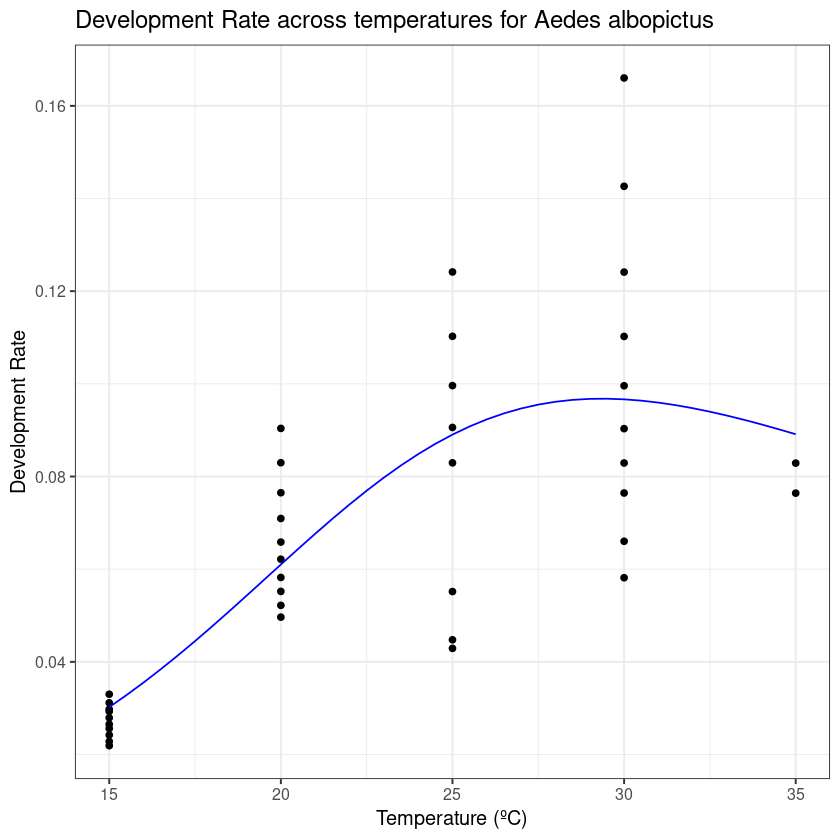

In [14]:
#visualize with new line
ggplot(df2, aes(ambienttemp, originaltraitvalue))+
  geom_point()+
  geom_line(aes(ambienttemp, .fitted), preds, col = 'blue') +
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Development Rate',
       title = 'Development Rate across temperatures for Aedes albopictus')